In [25]:
# for data
import json

import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for deep learning
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Permute, multiply, Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# for bert language model
# import transformers


In [2]:
# GPU optimization stuff

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
tf.compat.v1.disable_eager_execution()


### Read prepared datasets

In [3]:
DATA_PATH = 'data/'
MODEL_PATH = 'models/'

In [4]:
# split dataset
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_test = pd.read_csv(DATA_PATH + 'test.csv')

print(df_train.head())

# get X
X_train = df_train['text'].values
X_test = df_test['text'].values

# get target
y_train = df_train["y"].values
y_test = df_test["y"].values


                                                text  y
0  make tea water taste amazing 0 calorie great w...  1
1                                   delicious cheese  1
2                                   love go like mad  1
3      great candy bar wedding reception guest loved  1
4                                            delious  1


### Load prepared word embeddings

In [5]:
emb = json.load(open(DATA_PATH + 'words_emb.json'))

emb_matrix = np.array(list(emb.values()))
words = list(emb.keys())

MAX_LEN = 30

embedding_layer = Embedding(input_dim=emb_matrix.shape[0], output_dim=emb_matrix.shape[1], weights=[
                            emb_matrix], input_length=MAX_LEN, trainable=False)


### Define Bi-directional LSTM model

In [6]:
# code attention layer
def attention_layer(inputs, neurons):
    X = Permute((2, 1))(inputs)
    X = Dense(neurons, activation="softmax")(X)
    X = Permute((2, 1), name="attention")(X)
    X = multiply([inputs, X])

    return X


# model
def bid_lstm(input_shape):
    # input
    X_indices = Input(input_shape)

    # embedding
    embeddings = embedding_layer(X_indices)

    # apply attention
    X = attention_layer(embeddings, neurons=MAX_LEN)

    # 2 layers of bidirectional lstm
    X = Bidirectional(LSTM(
        units=MAX_LEN, dropout=0.2, return_sequences=True))(X)
    X = Bidirectional(LSTM(units=MAX_LEN, dropout=0.2))(X)

    # final dense layers
    X = Dense(64, activation='relu')(X)
    y_out = Dense(1, activation='sigmoid')(X)

    # compile
    model = Model(inputs=X_indices, outputs=y_out)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

    return model


model = bid_lstm((MAX_LEN,))

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 300)      12585300    ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 30)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 30)      930         ['permute[0][0]']                
                                                                                              

### Training

In [8]:
# tokenizing  sequences from training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_indices = tokenizer.texts_to_sequences(X_train)

# padding sequences to uniform length
X_train_indices = pad_sequences(X_train_indices, maxlen=MAX_LEN)


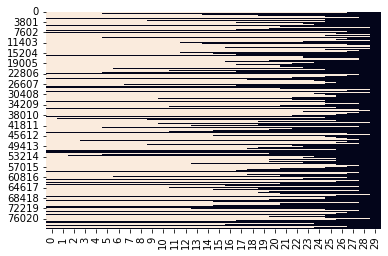

In [9]:
# visualize feature matrix
sns.heatmap(X_train_indices == 0, vmin=0, vmax=1, cbar=False)
plt.show()


In [10]:
# early stopping and model checkpoints

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
bst_model_path = MODEL_PATH + 'bid_lstm.h5'

model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)


In [13]:
# training

hist = model.fit(X_train_indices, y_train, validation_split=0.2,
                 batch_size=2048, epochs=50, callbacks=[early_stopping, model_checkpoint])


Train on 63852 samples, validate on 15964 samples
Epoch 1/50
63852/63852 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9289

c:\programdata\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


63852/63852 [==============================] - 7s 109us/sample - loss: 0.2242 - accuracy: 0.9289 - val_loss: 0.2202 - val_accuracy: 0.9302
Epoch 2/50
63852/63852 [==============================] - 5s 86us/sample - loss: 0.2201 - accuracy: 0.9289 - val_loss: 0.2158 - val_accuracy: 0.9301
Epoch 3/50
63852/63852 [==============================] - 5s 85us/sample - loss: 0.2175 - accuracy: 0.9289 - val_loss: 0.2127 - val_accuracy: 0.9301
Epoch 4/50
63852/63852 [==============================] - 6s 89us/sample - loss: 0.2168 - accuracy: 0.9290 - val_loss: 0.2158 - val_accuracy: 0.9301
Epoch 5/50
63852/63852 [==============================] - 6s 94us/sample - loss: 0.2151 - accuracy: 0.9294 - val_loss: 0.2090 - val_accuracy: 0.9303
Epoch 6/50
63852/63852 [==============================] - 6s 90us/sample - loss: 0.2143 - accuracy: 0.9289 - val_loss: 0.2123 - val_accuracy: 0.9300
Epoch 7/50
63852/63852 [==============================] - 5s 85us/sample - loss: 0.2133 - accuracy: 0.9292 - val_los

### Evaluation

In [14]:
# preparing sequences from test data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_test)

X_test_indices = tokenizer.texts_to_sequences(X_test)

# padding sequences to uniform length
X_test_indices = pad_sequences(X_test_indices, maxlen=MAX_LEN)


In [38]:
# loading model
model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

print('best val score: {}'.format(bst_val_score))

# evaluate
scores = model.evaluate(X_test_indices, y_test)

print('Accuracy: %.2f%%' % (scores[1]*100))

best val score: 0.19940009917405815
Accuracy: 92.53%


In [41]:
# test
predictions = model.predict(X_test_indices)
predictions = list(map(lambda x: 1 if x > 0.5 else 0, predictions))


[[    9  1408]
 [   83 18453]]


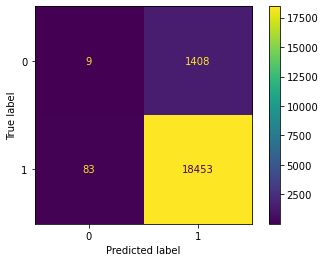

In [42]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

ConfusionMatrixDisplay(conf_matrix).plot()
